# Fossil Case: Ultra-Supercritical Power Plant

This notebook presents a flowsheet for an ultra-supercritical thermal power plant. The flowsheet is formulated as a simulation model with a turbine capacity of 436 MWe. The model is based on the flowsheet presented in USDOE report #DOE/FE-0400 (1999). A process flow diagram for this plant is given below.

<div>
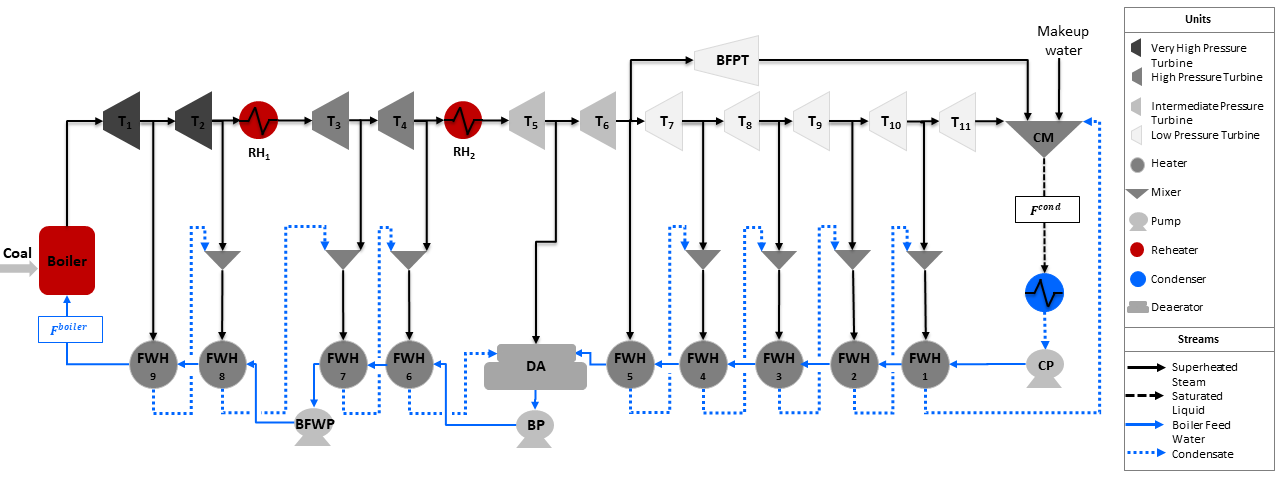
</div>

In this model, the thermal generator is assumed to use pulverized coal as the fuel. The power plant boiler is modeled as 3 different units boiler (_Boiler_), reheater 1 (_RH1_), and reheater 2 (_RH2_). All unit models used in the flowsheet are from IDAES unit model library. The list of specific unit models used to build the power plant model is tabulated below. More details regarding each unit model and governing equations can be found in its documentation. 

| IDAES Unit Model                | Units in the flowsheet                                  |
| :---                            | :----                                                   |
| _HelmTurbineStage_              | Turbine: _T1_ to _T11_ and _BFPT_                        |
| _HelmSplitter_                  | Turbine Splitters                                       |
| _Heater_                        | Boiler components: _Boiler_, _RH1_, & _RH2_             |
| _HelmMixer_                     | Mixers: _Condensate Mixer_, _Deaerator_                 |
| _HelmIsentropicCompressor_      | Pumps: _Condenser Pump_, _Booster Pump_, & _BFW Pump_   |
| _HeatExchanger_                 | Condenser and Feedwater Heaters: _FWH1_ to _FWH9_       |


The model can be accessed from dispatches repo, `ultra_supercritical_powerplant.py`. The model has 3 degrees of freedom:

   1. Boiler feed water flow: `m.fs.boiler.inlet.flow_mol`
   2. Boiler outlet pressure: `m.fs.boiler.outlet.pressure`
   3. Boiler outlet temperature: `m.fs.boiler.control_volume.properties_out[0].temperature`

In this implementation, the boiler outlet temperature is constrained to be _866 K_. To demonstrate the model, first, import all the libraries and packages need for the model

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import value
from idaes.core.solvers.get_solver import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from dispatches.models.fossil_case.ultra_supercritical_plant import ultra_supercritical_powerplant as usc

The power plant model uspp contains the methods `build_plant_model`, which instantiates all the unit models (`declare_unit_model`), connect them using Arcs (`_create_arcs`), sets model inputs (`set_model_inputs`), adds bounds and scaling factors to all variables in the flowsheets. The parameters such as efficiencies of turbines, areas of feedwater heat exchangers, and efficiency for pumps are estimated such that the overall performance of the power plant matches at base load of 436 MW matches to that of the reference report. Fixed pressure drops have been assumed for all units in the flowsheet. In addition, the outlet of condenser is assumed to be saturated liquid.
The following operational constraints are added in the model.
1. The power required for all pumps, i.e., booster pump, boiler feedwater pump, and condensate pump, is the same as generated from boiler feedwater turbine. W is power in MWe.

$$
        \sum(W_{booster pump} + W_{feedwater pump} + W_{condensate pump}) = W_{BFPT}
$$        

2. `PlantPowerOut` is given by the total turbine mechanical work

$$
        PlantPowerOut = \sum_{Unit}{Unit.MechanicalWork_{t}}
$$        

3. `PlantHeatDuty` is given as the sum of heat duties for Boiler units. `Unit` is in `[Boiler, RH1, RH2]`

$$
        PlantHeatDuty = \sum_{Unit}{Unit.HeatDuty_{t}}
$$        


In [2]:
# Build ultra supercritical power plant model
m = usc.build_plant_model()

Once the model is built, it can be initialized using the `initialize` method. Degrees of freedom is asserted to be 0 post initialization to ensure a completed model.

In [3]:
# Initialize the model (sequencial initialization and custom routines)
usc.initialize(m)

# Ensure after the model is initialized, the degrees of freedom = 0
assert degrees_of_freedom(m) == 0

2022-07-01 18:25:59 [INFO] idaes.init.fs.boiler.control_volume: Initialization Complete
2022-07-01 18:25:59 [INFO] idaes.init.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2022-07-01 18:25:59 [INFO] idaes.init.fs.turbine_splitter[1]: Initialization Complete: optimal - Optimal Solution Found
2022-07-01 18:25:59 [INFO] idaes.init.fs.turbine_splitter[2]: Initialization Complete: optimal - Optimal Solution Found
2022-07-01 18:25:59 [INFO] idaes.init.fs.reheater[1].control_volume: Initialization Complete
2022-07-01 18:25:59 [INFO] idaes.init.fs.reheater[1]: Initialization Complete: optimal - Optimal Solution Found
2022-07-01 18:25:59 [INFO] idaes.init.fs.turbine_splitter[3]: Initialization Complete: optimal - Optimal Solution Found
2022-07-01 18:25:59 [INFO] idaes.init.fs.turbine_splitter[4]: Initialization Complete: optimal - Optimal Solution Found
2022-07-01 18:25:59 [INFO] idaes.init.fs.reheater[2].control_volume: Initialization Complete
2022-07-01 18:25:59 [INFO] 

Create a solver object with IPOPT solver to solve the intialized model. The feedwater flow and boiler outlet pressure are varied to evaluate the model under off design conditions.

In [4]:
# Create the solver object
optarg = {
    "max_iter": 300,
    "halt_on_ampl_error": "yes"
}
solver = get_solver("ipopt", optarg)

## Flow vs Power

Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06
max_iter=300
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collect

   3  0.0000000e+00 1.79e-07 5.34e-02  -1.0 2.63e+02    -  9.90e-01 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   4.6566128730773926e-10    1.7881393432617188e-07
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.6566128730773926e-10    1.7881393432617188e-07


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 4
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 3
Total CPU secs in IPOPT (w/o fun

Plant Power (MW) = 482.5587031324392
Plant Heat Duty (MW) = 1018.6569959430444
Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06
max_iter=300
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes with

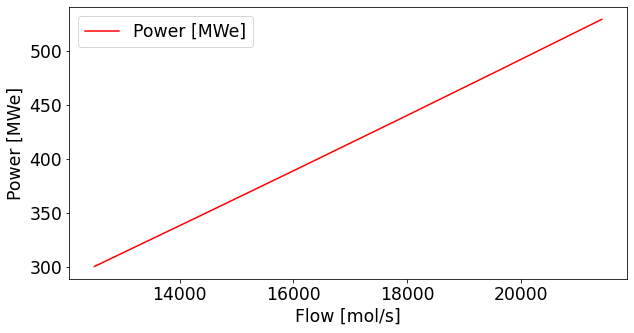

In [5]:
#   Solving the flowsheet and check result
flow_frac_list = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
flow = []
power = []
for i in flow_frac_list:
    m.fs.boiler.inlet.flow_mol.fix(i*17854)  # mol/s
    solver.solve(m, tee=True, symbolic_solver_labels=True)
    flow.append(value(m.fs.boiler.inlet.flow_mol[0]))
    power.append(value(m.fs.plant_power_out[0]))
    print('Plant Power (MW) =', value(m.fs.plant_power_out[0]))
    print('Plant Heat Duty (MW) =', value(m.fs.plant_heat_duty[0]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(flow, power,
        label='Power [MWe]', color='red')
ax.set_xlabel("Flow [mol/s]", fontsize="xx-large")
ax.set_ylabel("Power [MWe]", fontsize="xx-large")
ax.tick_params(axis='both', which='major', labelsize="xx-large")
ax.tick_params(axis='both', which='minor', labelsize="xx-large")
plt.legend(fontsize="xx-large", loc="upper left")
#plt.show()

## Pressure vs Power

Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06
max_iter=300
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collect

   1  0.0000000e+00 2.93e+01 1.85e+00  -1.0 9.67e+06    -  8.57e-01 1.00e+00h  1
   2  0.0000000e+00 8.67e-02 1.57e+01  -1.0 1.01e+07    -  7.06e-01 1.00e+00h  1
   3  0.0000000e+00 2.14e-06 2.29e-01  -1.0 7.86e+04    -  9.90e-01 1.00e+00h  1
   4  0.0000000e+00 2.98e-08 6.29e-05  -1.0 1.09e+00    -  9.90e-01 1.00e+00h  1

Number of Iterations....: 4

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   3.4924596548080444e-10    2.9802322387695312e-08
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.4924596548080444e-10    2.9802322387695312e-08


Number of objective function evaluations             = 5
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 5
Number of inequal

Plant Power (MW) = 429.1979916564438
Plant Heat Duty (MW) = 901.5421185699863
Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06
max_iter=300
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes withi

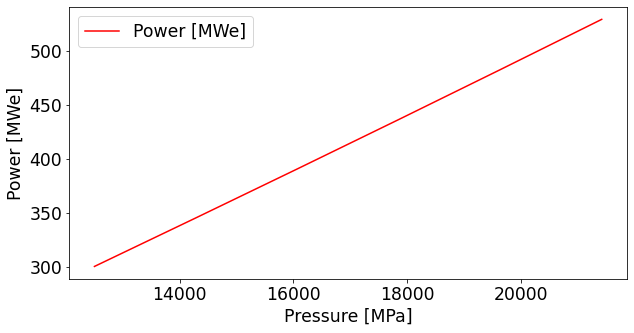

In [6]:
#   Solving the flowsheet and check result
pres_frac_list = [0.8, 0.9, 1.0, 1.1, 1.2]
pressure = []
power2 = []
for i in flow_frac_list:
    m.fs.boiler.inlet.flow_mol.fix(17854)  # mol/s
    m.fs.boiler.outlet.pressure.fix(i*31125980)
    solver.solve(m, tee=True, symbolic_solver_labels=True)
    pressure.append(value(m.fs.boiler.outlet.pressure[0])*1e-6)
    power2.append(value(m.fs.plant_power_out[0]))
    print('Plant Power (MW) =', value(m.fs.plant_power_out[0]))
    print('Plant Heat Duty (MW) =', value(m.fs.plant_heat_duty[0]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(flow, power,
        label='Power [MWe]', color='red')
ax.set_xlabel("Pressure [MPa]", fontsize="xx-large")
ax.set_ylabel("Power [MWe]", fontsize="xx-large")
ax.tick_params(axis='both', which='major', labelsize="xx-large")
ax.tick_params(axis='both', which='minor', labelsize="xx-large")
plt.legend(fontsize="xx-large", loc="upper left")
#plt.show()